# 随机梯度下降（SGD）

## 1. 核心原理

- **BGD（批量梯度下降）**：每次更新参数 $\beta$ 时，需要遍历整个数据集（如加州房价的 2 万条数据），计算平均梯度后再更新。  
    更新公式：  
    $$
    \beta = \beta - \alpha \cdot \frac{1}{n} \sum_{i=1}^{n} \nabla J_i
    $$
    > 类比：攒够 $n$ 个人的意见再做决定。

- **SGD（随机梯度下降）**：每看到一个样本，就立即更新一次参数。  
    更新公式：  
    $$
    \beta = \beta - \alpha \cdot \nabla J_i
    $$
    > 类比：听完一个人的意见立刻调头。
- 其中：
$$\nabla J = \frac{1}{n} X^T (X\beta - y)$$

## 2. 形象类比：迷雾中下山

- **BGD**：你在山顶，因浓雾看不清路。先派出 2 万个探测器测量四周坡度，取平均值后再迈出一大步。这步很准，但等待数据回传很久。
- **SGD**：你随机往一个方向踩一脚。如果感觉是下坡，就立刻跨步。虽然可能因踩到小石头（噪声）而走偏，但你走得极快，一秒能走几万步。


## 3. SGD 的优缺点

**优点：**
- **速度极快**：无需大型矩阵运算，处理海量数据时，SGD 可能已收敛，而 BGD 还在计算。
- **跳出局部最优**：路径“乱”，有助于跳出局部最小值，寻找全局最优。
- **在线学习**：可随新数据实时更新模型，无需重新加载全部数据。

**缺点：**
- **路径抖动**：不会像 BGD 那样平滑地滑向谷底，而是在终点附近不断“跳舞”（震荡），难以完全停在最低点。
- **对学习率敏感**：需随着迭代次数增加逐步减小学习率，才能最终“冷静”下来。


## 4. 处理要点

- 为保证梯度的期望等于真实梯度，通常在每一轮（Epoch）开始前，随机打乱（Shuffle）数据集顺序
- 由于 SGD 具有随机性，单一的高学习率会让模型在接近谷底时不断“跳跃”而无法停留在最优点（快到了，又减去一个高的值，就跑偏了），导致损失曲线后期剧烈震荡。通常采用 学习率衰减（Learning Rate Schedule），随着迭代次数增加，让 alpha 逐渐变小
        
        ```Python
        t0, t1 = 5, 50  # 学习率衰减函数参数

        def learning_schedule(t):
            return t0 / (t + t1)
        alpha = learning_schedule(iteration)
        ```
- 迭代次数一定要大，要超过样本数量，否则无法学习到全部样本



## 5. 进阶版：小批量梯度下降（Mini-Batch GD）

现实中很少用纯 BGD 或纯 SGD，常用折中方案：每次取一小批（如 32、64、128 个样本）计算梯度。

- 兼具 BGD 的矩阵运算效率（可利用 GPU/CPU 并行）
- 也有 SGD 的快速更新和节省内存的优点

| 方法        | 梯度更新依据   | 路径稳定性         | 内存/速度                | 适用场景                   |
|-------------|---------------|--------------------|--------------------------|----------------------------|
| BGD         | 全量样本      | 极稳，直达终点     | 慢，大数据容易爆内存     | 小数据集，追求极致精度     |
| SGD         | 1个样本       | 极抖，像醉汉走路   | 极快，内存消耗最低       | 在线学习，超大数据集初探   |
| Mini-Batch  | 32~128个样本  | 适中，波浪式前进   | 最优，充分利用矩阵加速   | 绝大多数深度/机器学习任务 |

SGD 最终测试集 MSE: 0.557228


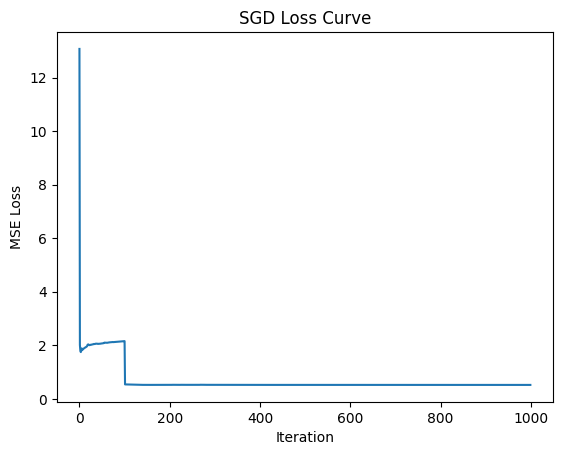

In [ ]:
#使用加州房价数据模拟SGD
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# 1. 加载并预处理数据
housing = fetch_california_housing()
X, y = housing.data, housing.target.reshape(-1, 1) # y 转为列向量
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 【关键】特征标准化：将所有特征缩放到均值为0，方差为1 （梯度下降对特征尺度敏感，标准化可以加速收敛）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 添加偏置项列 (1)，使用矩阵加速计算
X_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_b = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

# 记录损失变化
loss_history = []

# 2. 随机梯度下降法实现线性回归
# 随机初始化参数
alpha = 0.1  # 学习率
n_iterations = 100000 # 迭代次数
n_samples, n_features = X_b.shape # 样本数量和特征数量
beta = np.random.randn(n_features, 1) # 参数初始化
t0, t1 = 5, 50  # 学习率衰减函数参数

def learning_schedule(t):
    return t0 / (t + t1)

for iteration in range(n_iterations):
    # 随机选择一个样本
    random_index = np.random.randint(n_samples) # 从0到n_samples-1中随机选一个索引
    X_b_i = X_b[random_index:random_index+1] # 选取对应的特征行，保持二维结构
    y_i = y_train[random_index:random_index+1] # 选取对应的目标值，保持二维结构

    # 计算预测值
    y_pred_i = X_b_i.dot(beta) # 预测值
    error_i = y_pred_i - y_i # 误差
    
    gradients = 2 * X_b_i.T.dot(error_i) # 计算梯度

    # 【优化】使用动态学习率
    # SGD 具有随机性，单一的高学习率会让模型在接近谷底时不断“跳跃”而无法停留在最优点，导致损失曲线后期剧烈震荡
    alpha = learning_schedule(iteration)
    beta = beta - alpha * gradients

    # 【优化】每 100 步记录一次损失，节省计算资源
    if iteration % 100 == 0:
        current_loss = mean_squared_error(y_train, X_b.dot(beta))
        loss_history.append(current_loss)

# 3. 结果验证
y_pred = X_test_b.dot(beta)
final_mse = mean_squared_error(y_test, y_pred)

print(f"SGD 最终测试集 MSE: {final_mse:.6f}")
#画出损失函数的下降曲线
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.title('SGD Loss Curve')
plt.show()

MINI-BATCH GD最终测试集 MSE: 0.561341


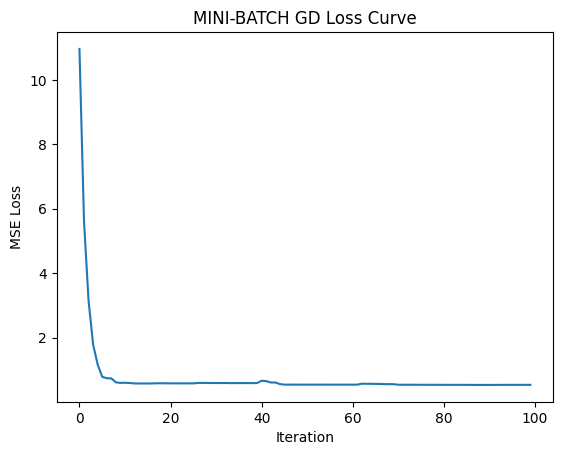

In [13]:
# 实践MINI-BATCH GD
# 1. 加载并预处理数据（同上）
housing = fetch_california_housing()
X, y = housing.data, housing.target.reshape(-1, 1) # y 转为列向量
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 【关键】特征标准化：将所有特征缩放到均值为0，方差为1 （梯度下降对特征尺度敏感，标准化可以加速收敛）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 添加偏置项列 (1)，使用矩阵加速计算
X_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_b = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

# 记录损失变化
loss_history = []

# 2. 随机梯度下降法实现线性回归
# 随机初始化参数
alpha = 0.1  # 学习率
n_iterations = 1000 # 迭代次数
n_samples, n_features = X_b.shape # 样本数量和特征数量
beta = np.random.randn(n_features, 1) # 参数初始化
t0, t1 = 5, 50  # 学习率衰减函数参数
batch_size = 32 # 小批量大小

def learning_schedule(t):
    return t0 / (t + t1)

for iteration in range(n_iterations):
    # 随机选择一批次样本
    random_indices = np.random.randint(n_samples, size=batch_size) # 随机选取32个样本
    X_b_i = X_b[random_indices] # 选取对应的特征行，保持二维结构
    y_i = y_train[random_indices] # 选取对应的目标值，保持二维结构

    # 计算梯度
    gradients = 1/batch_size * X_b_i.T.dot(X_b_i.dot(beta) - y_i)

    # 【优化】使用动态学习率
    # mini-SGD 具有随机性，单一的高学习率会让模型在接近谷底时不断“跳跃”而无法停留在最优点，导致损失曲线后期剧烈震荡
    alpha = learning_schedule(iteration)
    beta = beta - alpha * gradients

    # 【优化】每 10 步记录一次损失，节省计算资源
    if iteration % 10 == 0:
        current_loss = mean_squared_error(y_train, X_b.dot(beta))
        loss_history.append(current_loss)

# 3. 结果验证
y_pred = X_test_b.dot(beta)
final_mse = mean_squared_error(y_test, y_pred)

print(f"MINI-BATCH GD最终测试集 MSE: {final_mse:.6f}")
#画出损失函数的下降曲线
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.title('MINI-BATCH GD Loss Curve')
plt.show()